In [2]:
import torch
import corner
import numpy as np
import pylab as plt
from swyft.intensity import BallMask, ComboMask, Prior1d, Prior, Intensity
from tqdm import tqdm
import swyft

DEVICE = 'cuda'

%load_ext autoreload
%autoreload 2

In [41]:
def model(par):
    return dict(spec=np.linspace(-1, 1, 5)*par['A']*1000+par['B'])

def noise(obs, par):
    obs['spec'] += np.random.randn(*obs['spec'].shape)*0.2
    obs['spec'] *= 1e-3
    return obs

In [43]:
class Hooft(swyft.Module):
    def __init__(self, obs_shapes, factor = 1.):
        super().__init__(factor = factor)
        self.factor = factor
    
    def forward(self, x):
        return x['spec']

In [104]:
N = 2000

### Storage

In [105]:
cache = swyft.MemoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)})
#cache = swyft.DirectoryCache(params = ["A", "B"], obs_shapes = {"spec": (5,)}, path = "/home/weniger/zarr_test4")

Creating new cache.


### Prior

In [45]:
prior = Prior({"A": ["normal", 0.0, 0.001], "B": ["normal",  0., 1.]})

### Populating storage with simulations

In [73]:
N = 100
cache.grow(prior, N)
cache.simulate(model)

No new simulator runs required.
No simulations required.


In [74]:
points = swyft.Points(cache.sample(prior, N), cache, noise)

In [93]:
re = swyft.RatioEstimator([("A",), ("B",)], device=DEVICE, tail_args = dict(p=0.1))
re.train(points, max_epochs=10, batch_size=4, lr_schedule=[1e-3, 3e-4, 1e-4])

n_features = 5
Start training
LR iteration 0
Validation loss: 5.5454206466674805
Validation loss: 5.501899003982544
Validation loss: 5.20791220664978
Validation loss: 4.867943286895752
Validation loss: 4.721487283706665
Validation loss: 4.6069769859313965
Validation loss: 4.424546480178833
Validation loss: 4.308088064193726
Validation loss: 4.507257580757141
Total epochs: 9
LR iteration 1
Validation loss: 4.070536732673645
Validation loss: 4.370896816253662
Total epochs: 2
LR iteration 2
Validation loss: 3.827916145324707
Validation loss: 4.437814474105835
Total epochs: 2


In [94]:
obs0, par0 = points[0]['obs'], points[0]['par']

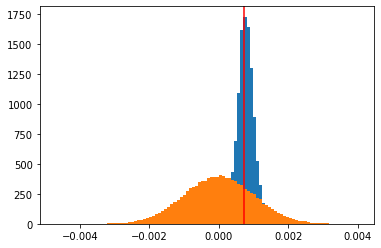

In [95]:
pars = prior.sample(100000)
lnL = re.lnL(obs0, pars)
plt.hist(pars['A'], weights = np.exp(lnL[('A',)]), bins = 100, density = True);
plt.hist(pars['A'], weights = 1+0*np.exp(lnL[('A',)]), bins = 100, density = True);
plt.axvline(par0['A'], color='r')

In [96]:
#sd = re.state_dict()
#re2 = re.from_state_dict(sd, device = DEVICE)

In [97]:
prior2 = prior.get_masked(obs0, re)

In [106]:
cache.grow(prior2, 1000)
cache.simulate(model)

Simulate:   4%|▍         | 39/972 [00:00<00:02, 388.13it/s]

Adding 972 new samples. Run simulator!


Simulate: 100%|██████████| 972/972 [00:02<00:00, 383.00it/s]


In [107]:
indices = cache.sample(prior2, 1000)
points = swyft.Points(indices, cache, noise)

In [108]:
re2 = swyft.RatioEstimator([("A",), ("B",), ("A", "B")], device=DEVICE, tail_args = dict(p=0.1))
re2.train(points, max_epochs=10, batch_size=16, lr_schedule=[1e-3, 3e-4, 1e-4, 3e-5])

n_features = 5
Start training
LR iteration 0
Validation loss: 19.779725313186646
Validation loss: 14.559207201004028
Validation loss: 13.276249885559082
Validation loss: 15.756184816360474
Total epochs: 4
LR iteration 1
Validation loss: 12.813742637634277
Validation loss: 12.782089948654175
Validation loss: 12.528722047805786
Validation loss: 12.11297345161438
Validation loss: 12.915589094161987
Total epochs: 5
LR iteration 2
Validation loss: 12.11564552783966
Validation loss: 11.113076090812683
Validation loss: 12.181163787841797
Total epochs: 3
LR iteration 3
Validation loss: 11.81281065940857
Validation loss: 11.551354169845581
Validation loss: 10.9965261220932
Validation loss: 12.496648907661438
Total epochs: 4


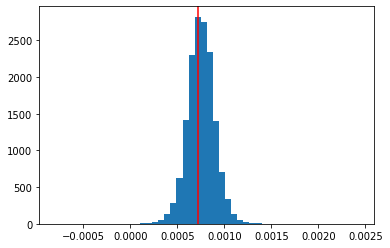

In [109]:
pars = prior2.sample(100000)
lnL = re2.lnL(obs0, pars)
plt.hist(pars['A'], weights = np.exp(lnL[('A',)]), bins = 50, density = True);
plt.axvline(par0['A'], color='r')

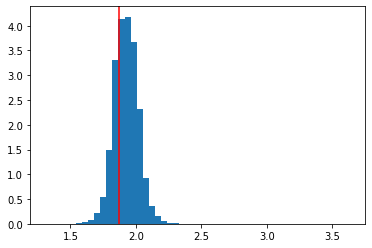

In [110]:
plt.hist(pars['B'], weights = np.exp(lnL[('B',)]), bins = 50, density = True);
plt.axvline(par0['B'], color='r')

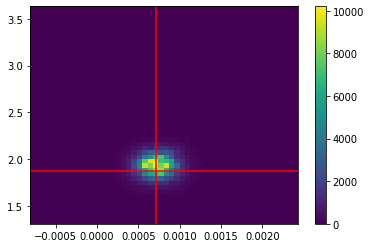

In [111]:
plt.hist2d(pars['A'], pars['B'], weights = np.exp(lnL[('A', 'B',)]), bins = 50, density = True);
plt.axhline(par0['B'], color='r')
plt.axvline(par0['A'], color='r')
plt.colorbar()
#plt.axvline(par0['B'], color='r')